# Synthetic Randomized SVD Benchmarks

Generate 50 low-rank noisy matrices (~10^6 entries), run deterministic SVD vs. randomized SVD, and average relative errors plus runtimes across all trials.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from time import perf_counter
from dataclasses import dataclass

plt.rcParams.update({"font.size": 12})
FIGURE_DIR = Path("figures/synthetic_matrices_notebook")
FIGURE_DIR.mkdir(parents=True, exist_ok=True)


In [14]:
SIZE_LIST = [10**2, 10**3, 10**4]
SHAPE_LIST = [(n, n) for n in SIZE_LIST]
NUM_MATRICES = len(SHAPE_LIST)
INTRINSIC_RANK_RANGE = (10, 200)
NOISE_RANGE = (0.01, 0.08)
DECAY = 0.92

RANKS_TO_TRY = [10, 20, 40, 80, 120, 160, 200]
POWER_ITERATIONS = [0, 1, 2, 3, 4]
OVERSAMPLING = 10
RANDOM_STATE = 2024
BASE_SEED = 5150
SAVE_FIGURES = True

@dataclass
class MatrixSpec:
    name: str
    shape: tuple[int, int]
    intrinsic_rank: int
    noise: float
    seed: int


def sanitize_filename(text: str, default: str = "figure") -> str:
    cleaned = "".join(c if c.isalnum() or c in ("-", "_") else "_" for c in text)
    cleaned = cleaned.strip("_")[:120]
    return cleaned or default


def save_named_figure(fig, label):
    if not SAVE_FIGURES:
        return
    filename = f"{sanitize_filename(label)}.png"
    path = FIGURE_DIR / filename
    fig.savefig(path, bbox_inches="tight", dpi=200)
    print(f"Saved figure -> {path}")


In [15]:
def generate_specs():
    rng = np.random.default_rng(BASE_SEED)
    specs = []
    for idx, shape in enumerate(SHAPE_LIST):
        intrinsic_rank = int(rng.integers(INTRINSIC_RANK_RANGE[0], INTRINSIC_RANK_RANGE[1] + 1))
        noise = float(rng.uniform(*NOISE_RANGE))
        seed = int(rng.integers(0, 1_000_000))
        specs.append(MatrixSpec(f"Matrix-{idx:03d}", shape, intrinsic_rank, noise, seed))
    return specs


def make_low_rank_matrix(spec: MatrixSpec):
    rng = np.random.default_rng(spec.seed)
    m, n = spec.shape
    k = min(spec.intrinsic_rank, m, n)
    left = rng.standard_normal((m, k))
    right = rng.standard_normal((k, n))
    singulars = DECAY ** np.arange(k)
    low_rank = (left * singulars) @ right
    noise = spec.noise * rng.standard_normal((m, n))
    return low_rank + noise


def truncated_svd(matrix):
    start = perf_counter()
    U, S, Vt = np.linalg.svd(matrix, full_matrices=False)
    return (U, S, Vt), perf_counter() - start


def randomized_svd(matrix, rank, oversampling, n_iter, random_state=None):
    matrix = np.asarray(matrix, dtype=np.float64)
    m, n = matrix.shape
    k = min(rank, m, n)
    ell = min(k + oversampling, n)
    rng = np.random.default_rng(random_state)
    projector = rng.standard_normal(size=(n, ell))
    sample = matrix @ projector
    for _ in range(max(n_iter, 0)):
        sample = matrix @ (matrix.T @ sample)
    Q, _ = np.linalg.qr(sample, mode="reduced")
    B = Q.T @ matrix
    start = perf_counter()
    Uh, S, Vt = np.linalg.svd(B, full_matrices=False)
    runtime = perf_counter() - start
    U = Q @ Uh
    return (U[:, :k], S[:k], Vt[:k, :]), runtime


def reconstruct(U, S, Vt, rank):
    r = min(rank, len(S))
    return (U[:, :r] * S[:r]) @ Vt[:r, :]


def relative_frobenius_error(original, approx):
    denom = np.linalg.norm(original, ord="fro")
    if denom == 0:
        return 0.0
    return np.linalg.norm(original - approx, ord="fro") / denom


In [16]:
print("Generating specs (sizes: 1e2, 1e3, 1e4) and running experiments ...")
matrix_specs = generate_specs()
records = []
for spec in matrix_specs:
    matrix = make_low_rank_matrix(spec)
    (U_svd, S_svd, Vt_svd), svd_runtime = truncated_svd(matrix)
    for rank in RANKS_TO_TRY:
        approx = reconstruct(U_svd, S_svd, Vt_svd, rank)
        err = relative_frobenius_error(matrix, approx)
        records.append({
            "matrix": spec.name,
            "shape": spec.shape,
            "method": "SVD",
            "rank": rank,
            "power_iterations": 0,
            "relative_error": err,
            "runtime_ms": svd_runtime * 1000,
        })
    for rank in RANKS_TO_TRY:
        for q in POWER_ITERATIONS:
            (Ur, Sr, Vtr), r_time = randomized_svd(
                matrix,
                rank,
                oversampling=OVERSAMPLING,
                n_iter=q,
                random_state=RANDOM_STATE,
            )
            approx = (Ur * Sr) @ Vtr
            err = relative_frobenius_error(matrix, approx)
            records.append({
                "matrix": spec.name,
                "shape": spec.shape,
                "method": "rSVD",
                "rank": rank,
                "power_iterations": q,
                "relative_error": err,
                "runtime_ms": r_time * 1000,
            })
metrics_df = pd.DataFrame(records)
metrics_df.sort_values(["shape", "method", "rank", "power_iterations"], inplace=True)
metrics_df.reset_index(drop=True, inplace=True)
metrics_df.head()


Generating specs (sizes: 1e2, 1e3, 1e4) and running experiments ...


,matrix,shape,method,rank,power_iterations,relative_error,runtime_ms
0,Matrix-000,"(100, 100)",SVD,10,0,3.632096e-01,47.394
1,Matrix-000,"(100, 100)",SVD,20,0,1.444916e-01,47.394
2,Matrix-000,"(100, 100)",SVD,40,0,2.272698e-02,47.394
3,Matrix-000,"(100, 100)",SVD,80,0,2.805404e-03,47.394
4,Matrix-000,"(100, 100)",SVD,120,0,2.234088e-15,47.394


In [17]:
latex_float = lambda x: f"{x:.4f}"
svd_table = (
    metrics_df[metrics_df["method"] == "SVD"]
    [["shape", "rank", "relative_error", "runtime_ms"]]
    .rename(columns={"shape": "Shape", "rank": "Rank", "relative_error": "Relative Error", "runtime_ms": "Runtime [ms]"})
)
print(svd_table.to_latex(index=False, float_format=latex_float,
      caption="Deterministic SVD metrics by matrix size", label="tab:synthetic_svd"))

rsvd_table = (
    metrics_df[metrics_df["method"] == "rSVD"]
    [["shape", "rank", "power_iterations", "relative_error", "runtime_ms"]]
    .rename(columns={"shape": "Shape", "rank": "Rank", "power_iterations": "q", "relative_error": "Relative Error", "runtime_ms": "Runtime [ms]"})
)
print(rsvd_table.to_latex(index=False, float_format=latex_float,
      caption="Randomized SVD metrics by matrix size", label="tab:synthetic_rsvd"))


\begin{table}
\caption{Deterministic SVD metrics by matrix size}
\label{tab:synthetic_svd}
\begin{tabular}{lrrr}
\toprule
Shape & Rank & Relative Error & Runtime [ms] \\
\midrule
(100, 100) & 10 & 0.3632 & 47.3940 \\
(100, 100) & 20 & 0.1445 & 47.3940 \\
(100, 100) & 40 & 0.0227 & 47.3940 \\
(100, 100) & 80 & 0.0028 & 47.3940 \\
(100, 100) & 120 & 0.0000 & 47.3940 \\
(100, 100) & 160 & 0.0000 & 47.3940 \\
(100, 100) & 200 & 0.0000 & 47.3940 \\
(1000, 1000) & 10 & 0.4273 & 267.7008 \\
(1000, 1000) & 20 & 0.1870 & 267.7008 \\
(1000, 1000) & 40 & 0.0352 & 267.7008 \\
(1000, 1000) & 80 & 0.0089 & 267.7008 \\
(1000, 1000) & 120 & 0.0082 & 267.7008 \\
(1000, 1000) & 160 & 0.0076 & 267.7008 \\
(1000, 1000) & 200 & 0.0070 & 267.7008 \\
(10000, 10000) & 10 & 0.4322 & 126104.3246 \\
(10000, 10000) & 20 & 0.1880 & 126104.3246 \\
(10000, 10000) & 40 & 0.0366 & 126104.3246 \\
(10000, 10000) & 80 & 0.0094 & 126104.3246 \\
(10000, 10000) & 120 & 0.0093 & 126104.3246 \\
(10000, 10000) & 160 & 0.0092 &

Saved figure -> figures/synthetic_matrices_notebook/size_vs_metrics_svd.png


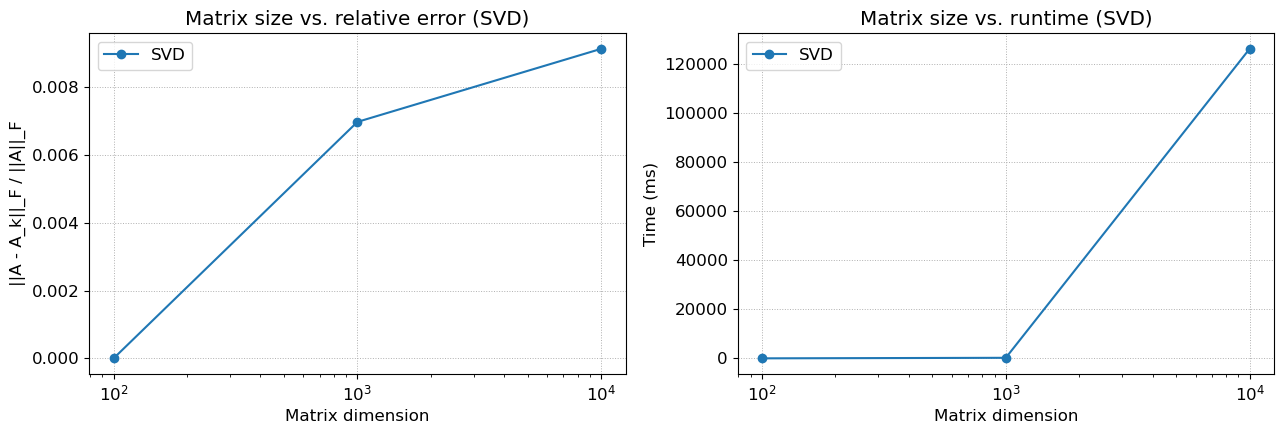

Saved figure -> figures/synthetic_matrices_notebook/size_vs_metrics_rsvd.png


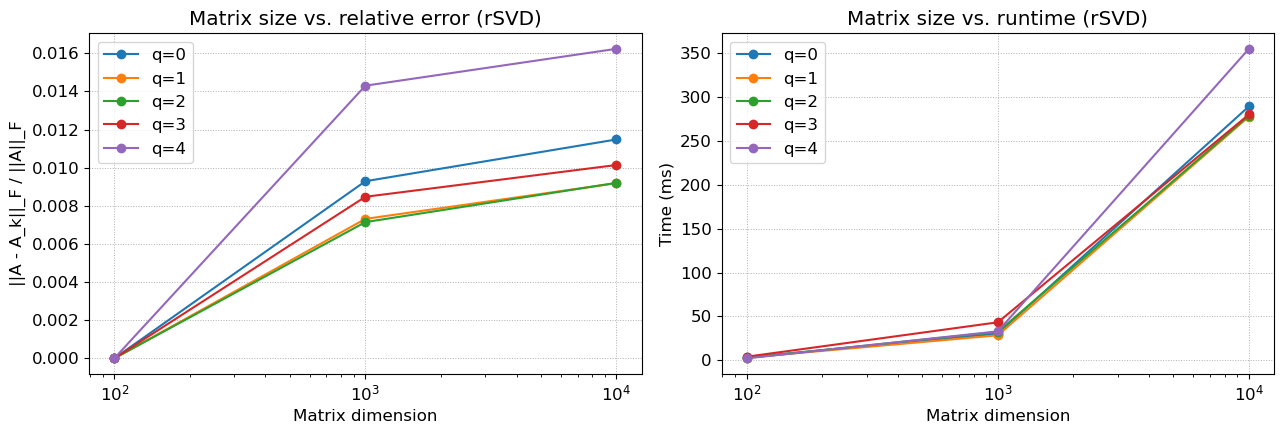

In [18]:
size_labels = [shape[0] for shape in SHAPE_LIST]
svd_errors = []
svd_runtimes = []
svd_max_rank = max(RANKS_TO_TRY)
for shape in SHAPE_LIST:
    subset = metrics_df[(metrics_df["method"] == "SVD") & (metrics_df["shape"] == shape) & (metrics_df["rank"] == svd_max_rank)]
    if subset.empty:
        svd_errors.append(np.nan)
        svd_runtimes.append(np.nan)
        continue
    row = subset.iloc[0]
    svd_errors.append(row["relative_error"])
    svd_runtimes.append(row["runtime_ms"])

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
axes[0].plot(size_labels, svd_errors, marker="o", label="SVD")
axes[1].plot(size_labels, svd_runtimes, marker="o", label="SVD")
for ax in axes:
    ax.set_xscale("log")
axes[0].set_title("Matrix size vs. relative error (SVD)")
axes[0].set_xlabel("Matrix dimension")
axes[0].set_ylabel("||A - A_k||_F / ||A||_F")
axes[0].grid(True, linestyle=":", linewidth=0.7)
axes[0].legend()
axes[1].set_title("Matrix size vs. runtime (SVD)")
axes[1].set_xlabel("Matrix dimension")
axes[1].set_ylabel("Time (ms)")
axes[1].grid(True, linestyle=":", linewidth=0.7)
axes[1].legend()
plt.tight_layout()
save_named_figure(fig, "size_vs_metrics_svd")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(13, 4.5))
for q in POWER_ITERATIONS:
    errors = []
    runtimes = []
    for shape in SHAPE_LIST:
        subset = metrics_df[(metrics_df["method"] == "rSVD") & (metrics_df["shape"] == shape) & (metrics_df["power_iterations"] == q) & (metrics_df["rank"] == svd_max_rank)]
        if subset.empty:
            errors.append(np.nan)
            runtimes.append(np.nan)
            continue
        row = subset.iloc[0]
        errors.append(row["relative_error"])
        runtimes.append(row["runtime_ms"])
    axes[0].plot(size_labels, errors, marker="o", label=f"q={q}")
    axes[1].plot(size_labels, runtimes, marker="o", label=f"q={q}")
for ax in axes:
    ax.set_xscale("log")
axes[0].set_title("Matrix size vs. relative error (rSVD)")
axes[0].set_xlabel("Matrix dimension")
axes[0].set_ylabel("||A - A_k||_F / ||A||_F")
axes[0].grid(True, linestyle=":", linewidth=0.7)
axes[0].legend()
axes[1].set_title("Matrix size vs. runtime (rSVD)")
axes[1].set_xlabel("Matrix dimension")
axes[1].set_ylabel("Time (ms)")
axes[1].grid(True, linestyle=":", linewidth=0.7)
axes[1].legend()
plt.tight_layout()
save_named_figure(fig, "size_vs_metrics_rsvd")
plt.show()
